Kindly read the README.md file before proceeding with this file.
In this file, we have made 5 different runs for the two models. Below are the details for it:
1. Simple CNN run with 50 sensors 500 snapshots and 500 epochs 
2. ResNet implementation with 50 sensors 200 epochs and 500 snapshots 
3. Simple CNN implementation with 5000 snapshots 100 sensors 200 epochs (not 500 due to time constraints during training) 
4. ResNet implementation with 500 snapshots 200 epochs and 100 sensors 
5. ResNet with 100 sensors 200 epochs and 5000 snapshots 

NOTE: The entire code is executable as long as you have the record_x.csv, record_y.csv & the pickle file that can be downloaded from the link in data_generation.ipynb

1. Simple CNN run with 50 sensors 500 snapshots and 500 epochs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os

# Set device to CUDA if available, otherwise CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

#MODEL ARCHITECTURE: Simple CNN Reconstructor

class SimpleCNNReconstructor(nn.Module):
    """
    PyTorch equivalent of the original Keras 7-layer CNN model.
    Structure: Input (2 channels) -> Conv7x7(48) -> [Conv7x7(48)] x 6 -> Conv3x3(1)
    """
    def __init__(self, dim_1, dim_2):
        super(SimpleCNNReconstructor, self).__init__()
        
        # 1st Conv Layer (Input: 2 channels, Output: 48 channels)
        self.conv1 = nn.Conv2d(2, 48, kernel_size=7, padding='same')
        
        # Six more 7x7 Conv layers with 48 filters
        layers = []
        for _ in range(6):
            # Each pair is Conv -> ReLU, matching the original Keras layer structure
            layers.append(nn.Conv2d(48, 48, kernel_size=7, padding='same'))
            layers.append(nn.ReLU())
        self.conv_stack = nn.Sequential(*layers)
        
        # Final 3x3 Conv layer (Output: 1 channel, linear activation)
        self.final_conv = nn.Conv2d(48, 1, kernel_size=3, padding='same')

    def forward(self, x):
        # Initial Conv + ReLU
        x = F.relu(self.conv1(x))
        
        # 6-layer stack
        x = self.conv_stack(x)
        
        # Final layer (linear output)
        x = self.final_conv(x)
        return x


dim_1 = 128
dim_2 = 48
sen_num_kind = 1
sen_num_var = 1

sen_num_kind_list = [50]  #NUMBER OF SENSORS
sen_num_var_list = [300] 
num_snapshots = 500 

try:

    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]

    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)

except FileNotFoundError as e:
    print(f"ERROR: Data file not found: {e.filename}. Please check your file paths.")
    exit()


x_ref, y_ref = np.meshgrid(yc, xc)

# The total number of snapshots processed is 500 (your inner loop limit)
total_samples = num_snapshots * sen_num_kind * sen_num_var 
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        
        for t in tqdm(range(500), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            #Simulate sparse sensor data
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            # Input Channel 1: Interpolation (Nearest Neighbor)
            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

# Convert NumPy arrays to PyTorch Tensors and PERMUTE CHANNELS (necessary for PyTorch as it was throwing datatype errors)
X_train_tensor = torch.from_numpy(X_train_np).float().permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.from_numpy(y_train_np).float().permute(0, 3, 1, 2).to(device)
X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

print(f"\nData Shape (N, C, H, W): X_train {X_train_tensor.shape}, y_train {y_train_tensor.shape}")


batch_size = 256 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. TRAINING PIPELINE

model = SimpleCNNReconstructor(dim_1, dim_2).to(device)

criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3) 


num_epochs = 500
best_val_loss = float('inf')
patience = 100
patience_counter = 0
model_save_path = './Model_2Dxysec_pytorch.pth'
history = {'loss': [], 'val_loss': []}

print("\nStarting PyTorch Training...")

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(test_loader)
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}')

  
    if avg_val_loss < best_val_loss:
        print("Epoch %05d: val_loss improved. Saving model to %s" % 
              (epoch + 1, model_save_path))
        best_val_loss = avg_val_loss
        patience_counter = 0 
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEpoch {epoch+1}: Early stopping triggered. Restoring best weights.")
        break

# Restore Best Weights
model.load_state_dict(torch.load(model_save_path, map_location=device))

#save results to csv
df_results = pd.DataFrame(history)
df_results['epoch'] = range(1, len(history['loss']) + 1)
df_results.to_csv('./Model_2Dxysec_pytorch.csv', index=False)
print("✅ Training complete. Results saved to './Model_2Dxysec_pytorch.csv'")

Using device: cuda


Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]






Kind Loop: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]



Data Shape (N, C, H, W): X_train torch.Size([350, 2, 128, 48]), y_train torch.Size([350, 1, 128, 48])

Starting PyTorch Training...
Epoch 1/500 - Loss: 2.372589 - Val Loss: 2.366446
Epoch 00001: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 2/500 - Loss: 2.327867 - Val Loss: 2.027590
Epoch 00002: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 3/500 - Loss: 2.961757 - Val Loss: 1.974609
Epoch 00003: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 4/500 - Loss: 2.087486 - Val Loss: 2.290425
Epoch 5/500 - Loss: 2.296833 - Val Loss: 2.306443
Epoch 6/500 - Loss: 2.306668 - Val Loss: 2.307090
Epoch 7/500 - Loss: 2.292321 - Val Loss: 2.307512
Epoch 8/500 - Loss: 2.307165 - Val Loss: 2.307689
Epoch 9/500 - Loss: 2.290207 - Val Loss: 2.307523
Epoch 10/500 - Loss: 2.312894 - Val Loss: 2.307195
Epoch 11/500 - Loss: 2.298568 - Val Loss: 2.306961
Epoch 12/500 - Loss: 2.280922 - Val Loss: 2.306744
Epoch 13/500 - Loss: 2.278801 - Val 

Using device: cuda


Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]






Kind Loop: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
/tmp/ipykernel_822543/3597500461.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


✅ Successfully loaded weights from ./Model_2Dxysec_pytorch.pth
Generating prediction for sample index 10 from the test set...


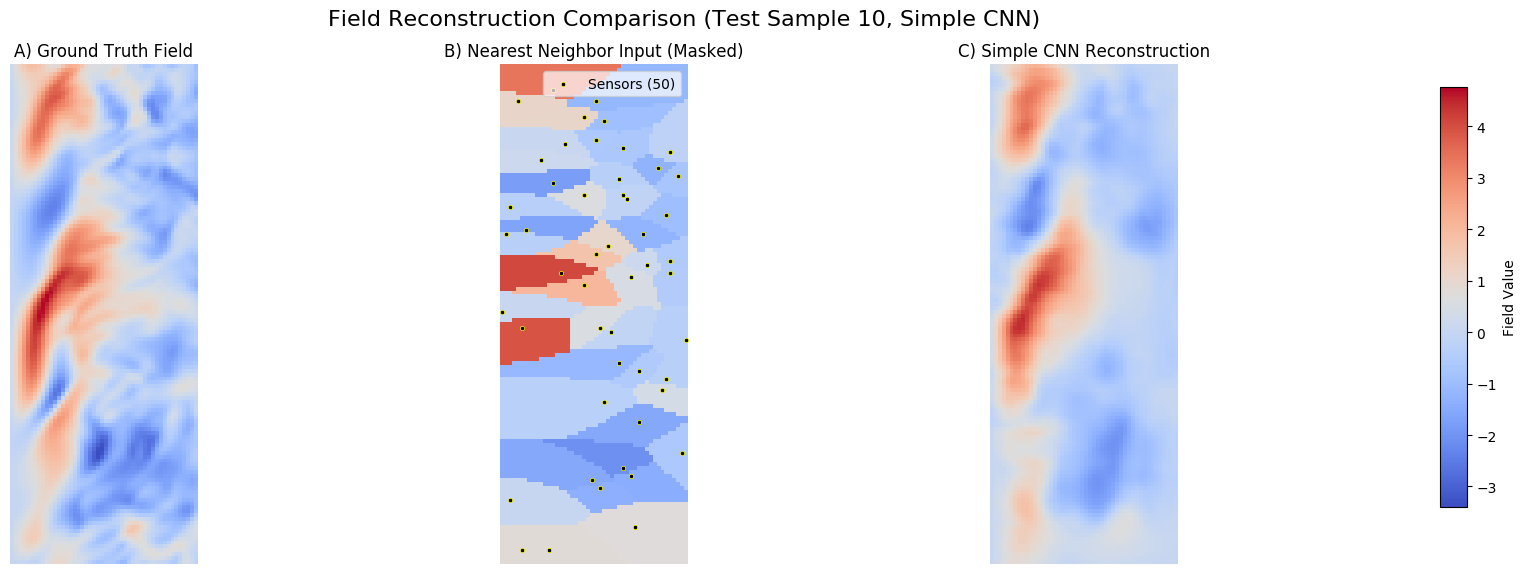


Prediction MSE (on this sample): 0.511248


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

class SimpleCNNReconstructor(nn.Module):
    
    def __init__(self, dim_1, dim_2):
        super(SimpleCNNReconstructor, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 48, kernel_size=7, padding='same')
        
        layers = []
        for _ in range(6):
            layers.append(nn.Conv2d(48, 48, kernel_size=7, padding='same'))
            layers.append(nn.ReLU())
        self.conv_stack = nn.Sequential(*layers)
        
        self.final_conv = nn.Conv2d(48, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.conv_stack(x)
        
        x = self.final_conv(x)
        return x

dim_1 = 128
dim_2 = 48
sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [50] 
sen_num_var_list = [300] 
num_snapshots = 500 

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]

    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)

except FileNotFoundError:
    print("ERROR: Data files not found. Cannot proceed with visualization.")
    exit()


x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var 
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        for t in tqdm(range(500), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42 
)

X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)


model = SimpleCNNReconstructor(dim_1, dim_2).to(device)
model_save_path = './Model_2Dxysec_pytorch.pth'

try:
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval() 
    print(f"✅ Successfully loaded weights from {model_save_path}")
except FileNotFoundError:
    print(f"ERROR: Model weights file not found at {model_save_path}. Please ensure you ran the PyTorch training script first.")
    exit()

sample_idx = 10
print(f"Generating prediction for sample index {sample_idx} from the test set...")

x_sample = X_test_tensor[sample_idx:sample_idx+1]
y_true = y_test_tensor[sample_idx]

with torch.no_grad():
    y_pred_tensor = model(x_sample)

x_input_np = x_sample.cpu().numpy()[0, 0, :, :] 
x_mask_np = x_sample.cpu().numpy()[0, 1, :, :]  
y_true_np = y_true.cpu().numpy()[0, :, :]      
y_pred_np = y_pred_tensor.cpu().numpy()[0, 0, :, :] 

def plot_field(data, title, ax, vmin, vmax):
    im = ax.imshow(data, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    return im

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

v_min = y_true_np.min()
v_max = y_true_np.max()

im1 = plot_field(y_true_np, "A) Ground Truth Field", axes[0], v_min, v_max)

im2 = plot_field(x_input_np, "B) Nearest Neighbor Input (Masked)", axes[1], v_min, v_max)
sensor_locs = np.argwhere(x_mask_np == 1)
if sensor_locs.size > 0:
    axes[1].scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='k', marker='o', s=10, 
                    edgecolor='yellow', linewidth=0.5, label='Sensors (50)')
    axes[1].legend(loc='upper right', framealpha=0.7)

im3 = plot_field(y_pred_np, "C) Simple CNN Reconstruction", axes[2], v_min, v_max)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Field Value')

plt.suptitle(f"Field Reconstruction Comparison (Test Sample {sample_idx}, Simple CNN)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.show()

error = np.mean((y_true_np - y_pred_np)**2)
print(f"\nPrediction MSE (on this sample): {error:.6f}")

2. ResNet implementation with 50 sensors 200 epochs and 500 snapshots

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
device = 'cuda'
if torch.cuda.is_available():
    # If using GPU, set device = 'cuda' otherwise CPU
    pass

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

#model arch

class ResidualBlock(nn.Module):
    """
    Creates a residual block with Batch Norm and Spatial Dropout.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        
        out += shortcut
        out = F.relu(out)
        return out



class ResNetReconstructor(nn.Module):
    def __init__(self, dim_1, dim_2):
        super(ResNetReconstructor, self).__init__()
        
        # Initial Feature Extraction (Input: 2 channels)
        self.initial_conv = nn.Conv2d(2, 64, kernel_size=5, padding='same')
        self.initial_bn = nn.BatchNorm2d(64)
        
        # Stack of Residual Blocks (Increased Depth for better feature extraction)
        self.res1 = ResidualBlock(64, 64, dropout_rate=0.1)
        self.res2 = ResidualBlock(64, 64, dropout_rate=0.1)
        
        self.res3 = ResidualBlock(64, 128, dropout_rate=0.2)
        self.res4 = ResidualBlock(128, 128, dropout_rate=0.2)
        
  
        self.res_added_1 = ResidualBlock(128, 128, dropout_rate=0.2) 
        self.res_added_2 = ResidualBlock(128, 128, dropout_rate=0.2) 
  
        
        self.res5 = ResidualBlock(128, 64, dropout_rate=0.1) 
        

        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        
        # Forward pass through new blocks
        x = self.res_added_1(x) 
        x = self.res_added_2(x) 
        
        x = self.res5(x)
        
        x = self.final_conv(x)
        return x


dim_1 = 128
dim_2 = 48

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]
    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)
except FileNotFoundError as e:
    print(f"ERROR: Data file not found: {e.filename}. Please check your file paths.")
    exit()

sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [50] 
sen_num_var_list = [300] 
num_snapshots = 500 

x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        for t in tqdm(range(num_snapshots), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

X_train_tensor = torch.from_numpy(X_train_np).float().permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.from_numpy(y_train_np).float().permute(0, 3, 1, 2).to(device)
X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

print(f"\nData Shape (N, C, H, W): X_train {X_train_tensor.shape}, y_train {y_train_tensor.shape}")

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = ResNetReconstructor(dim_1, dim_2).to(device)


opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
criterion = nn.MSELoss()


num_epochs = 200 
best_val_loss = float('inf')
patience = 25
patience_counter = 0
model_save_path = './Model_ResNet_2Dxysec_weights.pth'
history = {'loss': [], 'val_loss': []}

print("\nStarting Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(test_loader)
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        print("Epoch %05d: val_loss improved from %.6f to %.6f, saving model to %s" % 
              (epoch + 1, best_val_loss, avg_val_loss, model_save_path))
        best_val_loss = avg_val_loss
        patience_counter = 0 
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEpoch {epoch+1}: Early stopping triggered. Restoring best weights.")
        break

# Restore Best Weights
model.load_state_dict(torch.load(model_save_path))

df_results = pd.DataFrame(history)
df_results['epoch'] = range(1, len(history['loss']) + 1)
df_results.to_csv('./Model_2Dxysec_pytorch.csv', index=False)
print("✅ Training complete. Results saved to './Model_2Dxysec_pytorch.csv'")

Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]






Kind Loop: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



Data Shape (N, C, H, W): X_train torch.Size([350, 2, 128, 48]), y_train torch.Size([350, 1, 128, 48])

Starting Training...
Epoch 1/200 - Loss: 2.197735 - Val Loss: 2.426903
Epoch 00001: val_loss improved from inf to 2.426903, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 2/200 - Loss: 1.554736 - Val Loss: 1.808974
Epoch 00002: val_loss improved from 2.426903 to 1.808974, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 3/200 - Loss: 1.522056 - Val Loss: 1.558199
Epoch 00003: val_loss improved from 1.808974 to 1.558199, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 4/200 - Loss: 1.493074 - Val Loss: 1.494893
Epoch 00004: val_loss improved from 1.558199 to 1.494893, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 5/200 - Loss: 1.470953 - Val Loss: 1.416196
Epoch 00005: val_loss improved from 1.494893 to 1.416196, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 6/200 - Loss: 1.453148 - Val Loss: 1.458634
Epoch 7/200 - Loss: 1.433845 - Val 

✅ Successfully loaded enhanced weights from ./Model_ResNet_2Dxysec_weights.pth
Generating prediction for sample index 10 from the test set...


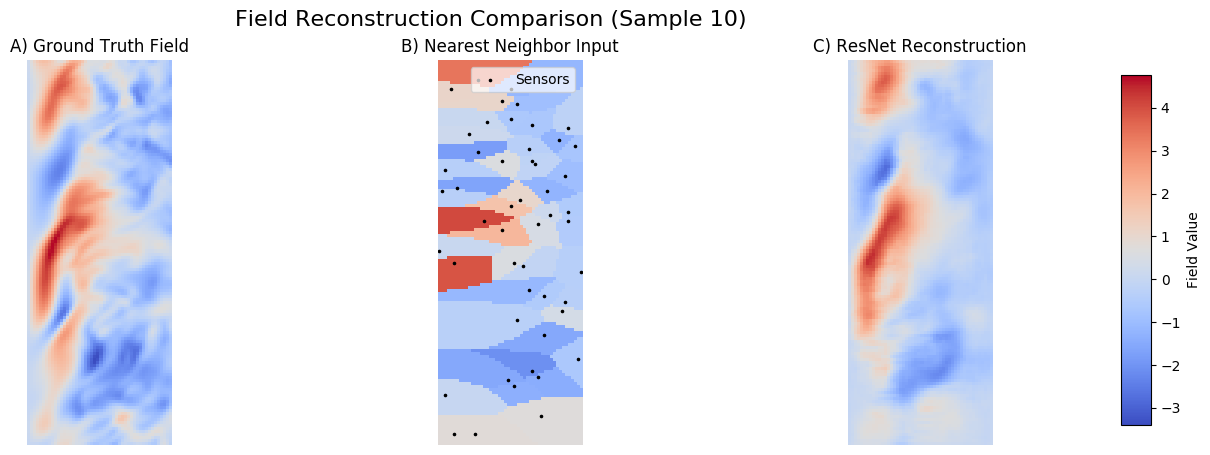


Prediction MSE (on this sample): 0.559721


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
import matplotlib.pyplot as plt

device = 'cuda' 
if not torch.cuda.is_available():
    device = 'cpu'
    print("⚠️ CUDA not available. Running on CPU.")


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += shortcut
        out = F.relu(out)
        return out

class ResNetReconstructor(nn.Module):
    def __init__(self, dim_1, dim_2):
        super(ResNetReconstructor, self).__init__()
        
        self.initial_conv = nn.Conv2d(2, 64, kernel_size=5, padding='same')
        self.initial_bn = nn.BatchNorm2d(64)
        
        self.res1 = ResidualBlock(64, 64, dropout_rate=0.1)
        self.res2 = ResidualBlock(64, 64, dropout_rate=0.1)
        
        self.res3 = ResidualBlock(64, 128, dropout_rate=0.2)
        self.res4 = ResidualBlock(128, 128, dropout_rate=0.2)
        
        self.res_added_1 = ResidualBlock(128, 128, dropout_rate=0.2) 
        self.res_added_2 = ResidualBlock(128, 128, dropout_rate=0.2) 
        
        self.res5 = ResidualBlock(128, 64, dropout_rate=0.1) 
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        
        x = self.res_added_1(x) 
        x = self.res_added_2(x) 
        
        x = self.res5(x)
        
        x = self.final_conv(x)
        return x

dim_1 = 128
dim_2 = 48
num_snapshots = 500
sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [50]
sen_num_var_list = [300]

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]
    with open("./ch_2Dxysec.pickle", 'rb') as f:
        omg_flc_all = pickle.load(f)
except FileNotFoundError as e:
    print(f"ERROR: Data file not found for loading: {e.filename}. Cannot proceed.")
    exit()

x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))
sample_index = 0
sen_num = sen_num_kind_list[0]
va = sen_num_var_list[0]

for t in range(num_snapshots):
    y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
    
    np.random.seed(va)
    sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
    sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

    sparse_data = np.zeros(sen_num)
    for s in range(sen_num):
        sparse_data[s] = omg_flc_all[t, :, :, 0][
            int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
        ]

    sparse_locations_ex = np.zeros((sen_num, 2))
    for i in range(sen_num):
        sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
        sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

    grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
    X_ki[sample_index, :, :, 0] = grid_z0

    mask_img = np.zeros(grid_z0.shape)
    for i in range(sen_num):
        mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
    X_ki[sample_index, :, :, 1] = mask_img
    
    sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

model = ResNetReconstructor(dim_1, dim_2).to(device)
model_save_path = './Model_ResNet_2Dxysec_weights.pth'

try:
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval() 
    print(f"✅ Successfully loaded enhanced weights from {model_save_path}")
except FileNotFoundError:
    print(f"ERROR: Model weights file not found at {model_save_path}. Please ensure you ran the training script with the enhanced model first.")
    exit()

sample_idx = 10 
print(f"Generating prediction for sample index {sample_idx} from the test set...")

x_sample = X_test_tensor[sample_idx:sample_idx+1]
y_true = y_test_tensor[sample_idx]

with torch.no_grad():
    y_pred_tensor = model(x_sample)

x_input_np = x_sample.cpu().numpy()[0, 0, :, :] 
x_mask_np = x_sample.cpu().numpy()[0, 1, :, :]  
y_true_np = y_true.cpu().numpy()[0, :, :]      
y_pred_np = y_pred_tensor.cpu().numpy()[0, 0, :, :] 

def plot_field(data, title, ax):
    v_min = y_true_np.min()
    v_max = y_true_np.max()
    
    im = ax.imshow(data, cmap='coolwarm', origin='lower', vmin=v_min, vmax=v_max)
    ax.set_title(title)
    ax.axis('off')
    return im

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = plot_field(y_true_np, "A) Ground Truth Field", axes[0])

im2 = plot_field(x_input_np, "B) Nearest Neighbor Input", axes[1])
sensor_locs = np.argwhere(x_mask_np == 1)
if sensor_locs.size > 0:
    axes[1].scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='k', marker='.', s=10, label='Sensors')
    axes[1].legend(loc='upper right', framealpha=0.7)

im3 = plot_field(y_pred_np, "C) ResNet Reconstruction", axes[2])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Field Value')

plt.suptitle(f"Field Reconstruction Comparison (Sample {sample_idx})", fontsize=16)
plt.show()

error = np.mean((y_true_np - y_pred_np)**2)
print(f"\nPrediction MSE (on this sample): {error:.6f}")

3. Simple CNN implementation with 5000 snapshots 100 sensors 200 epochs (not 500 due to time constraints during training)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

class SimpleCNNReconstructor(nn.Module):
    
    def __init__(self, dim_1, dim_2):
        super(SimpleCNNReconstructor, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 48, kernel_size=7, padding='same')
        
        layers = []
        for _ in range(6):
            layers.append(nn.Conv2d(48, 48, kernel_size=7, padding='same'))
            layers.append(nn.ReLU())
        self.conv_stack = nn.Sequential(*layers)
        
        self.final_conv = nn.Conv2d(48, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.conv_stack(x)
        
        x = self.final_conv(x)
        return x

dim_1 = 128
dim_2 = 48
sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [100] 
sen_num_var_list = [300] 
num_snapshots = 5000 

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]

    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)

except FileNotFoundError as e:
    print(f"ERROR: Data file not found: {e.filename}. Please check your file paths.")
    exit()


x_ref, y_ref = np.meshgrid(yc, xc)

total_samples = num_snapshots * sen_num_kind * sen_num_var 
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        
        for t in tqdm(range(5000), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42 
)

X_train_tensor = torch.from_numpy(X_train_np).float().permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.from_numpy(y_train_np).float().permute(0, 3, 1, 2).to(device)
X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

print(f"\nData Shape (N, C, H, W): X_train {X_train_tensor.shape}, y_train {y_train_tensor.shape}")

batch_size = 256 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SimpleCNNReconstructor(dim_1, dim_2).to(device)

criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3) 

num_epochs = 200 
best_val_loss = float('inf')
patience = 100
patience_counter = 0
model_save_path = './Model_2Dxysec_pytorch.pth'
history = {'loss': [], 'val_loss': []}

print("\nStarting PyTorch Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(test_loader)
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        print("Epoch %05d: val_loss improved. Saving model to %s" % 
              (epoch + 1, model_save_path))
        best_val_loss = avg_val_loss
        patience_counter = 0 
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEpoch {epoch+1}: Early stopping triggered. Restoring best weights.")
        break

model.load_state_dict(torch.load(model_save_path, map_location=device))

df_results = pd.DataFrame(history)
df_results['epoch'] = range(1, len(history['loss']) + 1)
df_results.to_csv('./Model_2Dxysec_pytorch.csv', index=False)
print("✅ Training complete. Results saved to './Model_2Dxysec_pytorch.csv'")

Using device: cuda


Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]





































































Kind Loop: 100%|██████████| 1/1 [00:06<00:00,  6.97s/it]



Data Shape (N, C, H, W): X_train torch.Size([3500, 2, 128, 48]), y_train torch.Size([3500, 1, 128, 48])

Starting PyTorch Training...
Epoch 1/200 - Loss: 2.522288 - Val Loss: 2.319849
Epoch 00001: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 2/200 - Loss: 2.112275 - Val Loss: 1.952251
Epoch 00002: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 3/200 - Loss: 1.608773 - Val Loss: 1.326634
Epoch 00003: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 4/200 - Loss: 1.263385 - Val Loss: 1.197697
Epoch 00004: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 5/200 - Loss: 1.120383 - Val Loss: 1.029676
Epoch 00005: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 6/200 - Loss: 1.027041 - Val Loss: 1.030296
Epoch 7/200 - Loss: 0.959982 - Val Loss: 0.920228
Epoch 00007: val_loss improved. Saving model to ./Model_2Dxysec_pytorch.pth
Epoch 8/200 - Loss: 0.907157 - Val Loss: 0.885799
Epoch 000

Using device: cuda


Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]






































































Kind Loop: 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


✅ Successfully loaded weights from ./Model_2Dxysec_pytorch.pth
Generating prediction for sample index 10 from the test set...


/tmp/ipykernel_822543/2987463248.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])


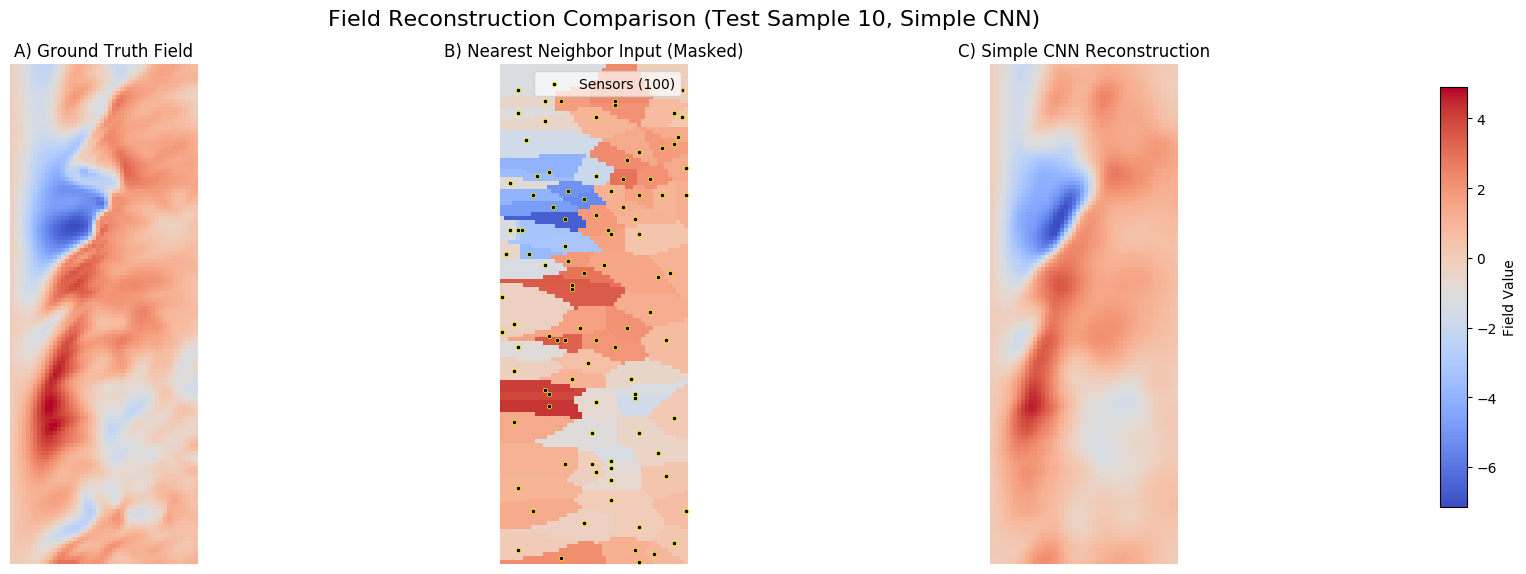


Prediction MSE (on this sample): 0.470670


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

class SimpleCNNReconstructor(nn.Module):
    
    def __init__(self, dim_1, dim_2):
        super(SimpleCNNReconstructor, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 48, kernel_size=7, padding='same')
        
        layers = []
        for _ in range(6):
            layers.append(nn.Conv2d(48, 48, kernel_size=7, padding='same'))
            layers.append(nn.ReLU())
        self.conv_stack = nn.Sequential(*layers)
        
        self.final_conv = nn.Conv2d(48, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.conv_stack(x)
        
        x = self.final_conv(x)
        return x

dim_1 = 128
dim_2 = 48
sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [100] 
sen_num_var_list = [300] 
num_snapshots = 5000 

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]

    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)

except FileNotFoundError:
    print("ERROR: Data files not found. Cannot proceed with visualization.")
    exit()


x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var 
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        for t in tqdm(range(5000), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42 
)

X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)


model = SimpleCNNReconstructor(dim_1, dim_2).to(device)
model_save_path = './Model_2Dxysec_pytorch.pth'

try:
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval() 
    print(f"✅ Successfully loaded weights from {model_save_path}")
except FileNotFoundError:
    print(f"ERROR: Model weights file not found at {model_save_path}. Please ensure you ran the PyTorch training script first.")
    exit()

sample_idx = 10
print(f"Generating prediction for sample index {sample_idx} from the test set...")

x_sample = X_test_tensor[sample_idx:sample_idx+1]
y_true = y_test_tensor[sample_idx]

with torch.no_grad():
    y_pred_tensor = model(x_sample)

x_input_np = x_sample.cpu().numpy()[0, 0, :, :] 
x_mask_np = x_sample.cpu().numpy()[0, 1, :, :]  
y_true_np = y_true.cpu().numpy()[0, :, :]      
y_pred_np = y_pred_tensor.cpu().numpy()[0, 0, :, :] 

def plot_field(data, title, ax, vmin, vmax):
    im = ax.imshow(data, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    return im

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

v_min = y_true_np.min()
v_max = y_true_np.max()

im1 = plot_field(y_true_np, "A) Ground Truth Field", axes[0], v_min, v_max)

im2 = plot_field(x_input_np, "B) Nearest Neighbor Input (Masked)", axes[1], v_min, v_max)
sensor_locs = np.argwhere(x_mask_np == 1)
if sensor_locs.size > 0:
    axes[1].scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='k', marker='o', s=10, 
                    edgecolor='yellow', linewidth=0.5, label='Sensors (100)')
    axes[1].legend(loc='upper right', framealpha=0.7)

im3 = plot_field(y_pred_np, "C) Simple CNN Reconstruction", axes[2], v_min, v_max)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Field Value')

plt.suptitle(f"Field Reconstruction Comparison (Test Sample {sample_idx}, Simple CNN)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.show()

error = np.mean((y_true_np - y_pred_np)**2)
print(f"\nPrediction MSE (on this sample): {error:.6f}")

In [ ]:

# 4. FINAL MEAN TEST MSE CALCULATION


print("\nCalculating Final Mean Test MSE...")

model.eval()
total_test_loss = 0.0

final_criterion = nn.MSELoss()

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        
        outputs = model(inputs)
        loss = final_criterion(outputs, targets)
        total_test_loss += loss.item()

mean_test_mse = total_test_loss / len(test_loader)

print(f"\nFinal Model Path: {model_save_path}")
print(f"Total Test Samples: {len(X_test_tensor)}")
print(f"Final Mean Test MSE: {mean_test_mse:.8f}")


df_results = pd.DataFrame(history)
df_results['epoch'] = range(1, len(history['loss']) + 1)
df_results['final_test_mse'] = mean_test_mse # Add the final score to the results DataFrame
df_results.to_csv('./Model_2Dxysec_pytorch_100_sensors.csv', index=False)
print("✅ Training complete. Results saved and final MSE included in the CSV.")


Calculating Final Mean Test MSE...


Testing: 100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


Final Model Path: ./Model_ResNet_2Dxysec_weights.pth
Total Test Samples: 150
Final Mean Test MSE: 0.44985726
✅ Training complete. Results saved and final MSE included in the CSV.


4. ResNet implementation with 500 snapshots 200 epochs and 100 sensors

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os

device = 'cuda'
if torch.cuda.is_available():
    pass

torch.manual_seed(42)
np.random.seed(42)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        
        out += shortcut
        out = F.relu(out)
        return out


#model arch

class ResNetReconstructor(nn.Module):
    def __init__(self, dim_1, dim_2):
        super(ResNetReconstructor, self).__init__()
        
        self.initial_conv = nn.Conv2d(2, 64, kernel_size=5, padding='same')
        self.initial_bn = nn.BatchNorm2d(64)
        
        self.res1 = ResidualBlock(64, 64, dropout_rate=0.1)
        self.res2 = ResidualBlock(64, 64, dropout_rate=0.1)
        
        self.res3 = ResidualBlock(64, 128, dropout_rate=0.2)
        self.res4 = ResidualBlock(128, 128, dropout_rate=0.2)
        
        self.res_added_1 = ResidualBlock(128, 128, dropout_rate=0.2) 
        self.res_added_2 = ResidualBlock(128, 128, dropout_rate=0.2) 
        
        self.res5 = ResidualBlock(128, 64, dropout_rate=0.1) 
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        
        x = self.res_added_1(x) 
        x = self.res_added_2(x) 
        
        x = self.res5(x)
        
        x = self.final_conv(x)
        return x

#standard data preparation
dim_1 = 128
dim_2 = 48

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]
    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)
except FileNotFoundError as e:
    print(f"ERROR: Data file not found: {e.filename}. Please check your file paths.")
    exit()

sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [100] 
sen_num_var_list = [300] 
num_snapshots = 500 

x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        for t in tqdm(range(num_snapshots), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

X_train_tensor = torch.from_numpy(X_train_np).float().permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.from_numpy(y_train_np).float().permute(0, 3, 1, 2).to(device)
X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

print(f"\nData Shape (N, C, H, W): X_train {X_train_tensor.shape}, y_train {y_train_tensor.shape}")

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#training
model = ResNetReconstructor(dim_1, dim_2).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
criterion = nn.MSELoss()

num_epochs = 200 
best_val_loss = float('inf')
patience = 25
patience_counter = 0
model_save_path = './Model_ResNet_2Dxysec_weights.pth'
history = {'loss': [], 'val_loss': []}

print("\nStarting Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(test_loader)
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        print("Epoch %05d: val_loss improved from %.6f to %.6f, saving model to %s" % 
              (epoch + 1, best_val_loss, avg_val_loss, model_save_path))
        best_val_loss = avg_val_loss
        patience_counter = 0 
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEpoch {epoch+1}: Early stopping triggered. Restoring best weights.")
        break

model.load_state_dict(torch.load(model_save_path))


df_results = pd.DataFrame(history)
df_results['epoch'] = range(1, len(history['loss']) + 1)
df_results.to_csv('./Model_2Dxysec_pytorch.csv', index=False)
print("✅ Training complete. Results saved to './Model_2Dxysec_pytorch.csv'")

Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]







Kind Loop: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]



Data Shape (N, C, H, W): X_train torch.Size([350, 2, 128, 48]), y_train torch.Size([350, 1, 128, 48])

Starting Training...
Epoch 1/200 - Loss: 1.552264 - Val Loss: 2.137240
Epoch 00001: val_loss improved from inf to 2.137240, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 2/200 - Loss: 0.978063 - Val Loss: 1.370042
Epoch 00002: val_loss improved from 2.137240 to 1.370042, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 3/200 - Loss: 0.944494 - Val Loss: 0.996906
Epoch 00003: val_loss improved from 1.370042 to 0.996906, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 4/200 - Loss: 0.924229 - Val Loss: 0.890395
Epoch 00004: val_loss improved from 0.996906 to 0.890395, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 5/200 - Loss: 0.904513 - Val Loss: 0.906621
Epoch 6/200 - Loss: 0.884203 - Val Loss: 0.893466
Epoch 7/200 - Loss: 0.856747 - Val Loss: 0.858394
Epoch 00007: val_loss improved from 0.890395 to 0.858394, saving model to ./Model_ResNet_2Dxys

✅ Successfully loaded enhanced weights from ./Model_ResNet_2Dxysec_weights.pth
Generating prediction for sample index 10 from the test set...


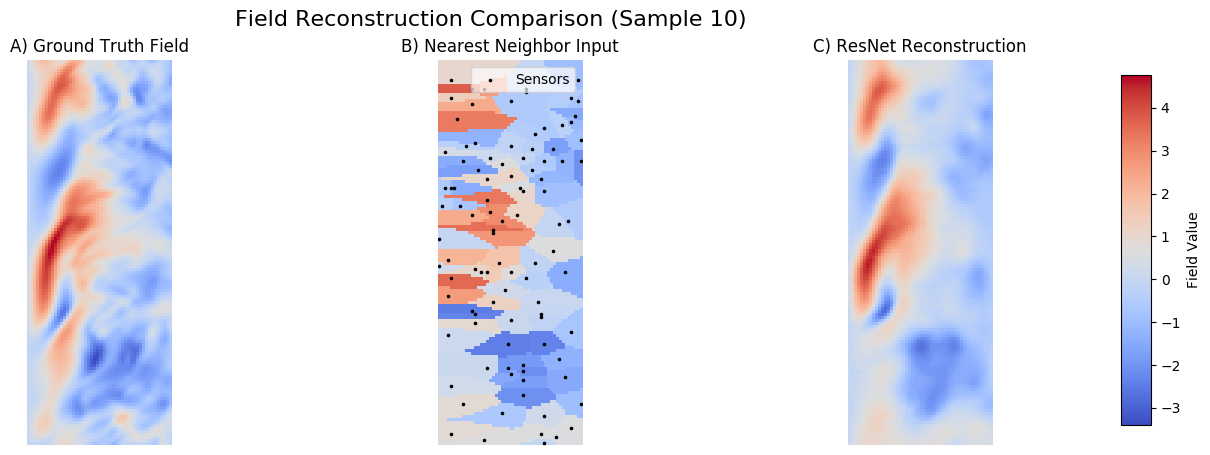


Prediction MSE (on this sample): 0.292039


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
import matplotlib.pyplot as plt

# =============================
# 1. MODEL DEFINITIONS (MATCHES ENHANCED TRAINING SCRIPT)
# =============================

device = 'cuda' 
if not torch.cuda.is_available():
    device = 'cpu'
    print("⚠️ CUDA not available. Running on CPU.")


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += shortcut
        out = F.relu(out)
        return out

class ResNetReconstructor(nn.Module):
    def __init__(self, dim_1, dim_2):
        super(ResNetReconstructor, self).__init__()
        
        self.initial_conv = nn.Conv2d(2, 64, kernel_size=5, padding='same')
        self.initial_bn = nn.BatchNorm2d(64)
        
        self.res1 = ResidualBlock(64, 64, dropout_rate=0.1)
        self.res2 = ResidualBlock(64, 64, dropout_rate=0.1)
        
        self.res3 = ResidualBlock(64, 128, dropout_rate=0.2)
        self.res4 = ResidualBlock(128, 128, dropout_rate=0.2)
        
        self.res_added_1 = ResidualBlock(128, 128, dropout_rate=0.2) 
        self.res_added_2 = ResidualBlock(128, 128, dropout_rate=0.2) 
        
        self.res5 = ResidualBlock(128, 64, dropout_rate=0.1) 
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        
        x = self.res_added_1(x) 
        x = self.res_added_2(x) 
        
        x = self.res5(x)
        
        x = self.final_conv(x)
        return x

# =============================
# 2. DATA LOADING & PREPARATION (Test Split)
# =============================
dim_1 = 128
dim_2 = 48
num_snapshots = 500
sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [100]
sen_num_var_list = [300]

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]
    with open("./ch_2Dxysec.pickle", 'rb') as f:
        omg_flc_all = pickle.load(f)
except FileNotFoundError as e:
    print(f"ERROR: Data file not found for loading: {e.filename}. Cannot proceed.")
    exit()

x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))
sample_index = 0
sen_num = sen_num_kind_list[0]
va = sen_num_var_list[0]

for t in range(num_snapshots):
    y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
    
    np.random.seed(va)
    sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
    sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

    sparse_data = np.zeros(sen_num)
    for s in range(sen_num):
        sparse_data[s] = omg_flc_all[t, :, :, 0][
            int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
        ]

    sparse_locations_ex = np.zeros((sen_num, 2))
    for i in range(sen_num):
        sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
        sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

    grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
    X_ki[sample_index, :, :, 0] = grid_z0

    mask_img = np.zeros(grid_z0.shape)
    for i in range(sen_num):
        mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
    X_ki[sample_index, :, :, 1] = mask_img
    
    sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

# =============================
# 3. LOAD MODEL AND PREDICT
# =============================

model = ResNetReconstructor(dim_1, dim_2).to(device)
model_save_path = './Model_ResNet_2Dxysec_weights.pth'

try:
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval() 
    print(f"✅ Successfully loaded enhanced weights from {model_save_path}")
except FileNotFoundError:
    print(f"ERROR: Model weights file not found at {model_save_path}. Please ensure you ran the training script with the enhanced model first.")
    exit()

sample_idx = 10 
print(f"Generating prediction for sample index {sample_idx} from the test set...")

x_sample = X_test_tensor[sample_idx:sample_idx+1]
y_true = y_test_tensor[sample_idx]

with torch.no_grad():
    y_pred_tensor = model(x_sample)

x_input_np = x_sample.cpu().numpy()[0, 0, :, :] 
x_mask_np = x_sample.cpu().numpy()[0, 1, :, :]  
y_true_np = y_true.cpu().numpy()[0, :, :]      
y_pred_np = y_pred_tensor.cpu().numpy()[0, 0, :, :] 

# =============================
# 4. VISUALIZATION
# =============================

def plot_field(data, title, ax):
    """Utility function to plot a 2D field with consistent settings."""
    v_min = y_true_np.min()
    v_max = y_true_np.max()
    
    im = ax.imshow(data, cmap='coolwarm', origin='lower', vmin=v_min, vmax=v_max)
    ax.set_title(title)
    ax.axis('off')
    return im

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = plot_field(y_true_np, "A) Ground Truth Field", axes[0])

im2 = plot_field(x_input_np, "B) Nearest Neighbor Input", axes[1])
sensor_locs = np.argwhere(x_mask_np == 1)
if sensor_locs.size > 0:
    axes[1].scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='k', marker='.', s=10, label='Sensors')
    axes[1].legend(loc='upper right', framealpha=0.7)

im3 = plot_field(y_pred_np, "C) ResNet Reconstruction", axes[2])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Field Value')

plt.suptitle(f"Field Reconstruction Comparison (Sample {sample_idx})", fontsize=16)
plt.show()

error = np.mean((y_true_np - y_pred_np)**2)
print(f"\nPrediction MSE (on this sample): {error:.6f}")

In [ ]:
print("\nCalculating Final Mean Test MSE and RMSE using best weights...")

model.eval()
total_test_mse = 0.0
final_criterion = nn.MSELoss() 

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        outputs = model(inputs)
        
        # Calculate MSE for the current batch
        batch_mse = final_criterion(outputs, targets)
        
        # Accumulate the batch MSE values
        total_test_mse += batch_mse.item()

# 1. Calculate the overall Mean Test MSE
mean_test_mse = total_test_mse / len(test_loader)

# 2. Calculate the Average RMSE (Root Mean Squared Error)
mean_test_rmse = np.sqrt(mean_test_mse) 

print(f"\nFinal Test Set Results:")
print(f"  Total Test Samples: {len(X_test_tensor)}")
print(f"  Mean Test MSE: {mean_test_mse:.8f}")



Calculating Final Mean Test MSE and RMSE using best weights...


Testing: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s]


Final Test Set Results:
  Total Test Samples: 150
  Mean Test MSE: 0.44985726


5. ResNet with 100 sensors 200 epochs and 5000 snapshots

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os


device = 'cuda'
if torch.cuda.is_available():
    # If using GPU, set device = 'cuda'
    pass

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)



class ResidualBlock(nn.Module):
    """
    Creates a residual block with Batch Norm and Spatial Dropout.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        
        out += shortcut
        out = F.relu(out)
        return out


class ResNetReconstructor(nn.Module):
    def __init__(self, dim_1, dim_2):
        super(ResNetReconstructor, self).__init__()
        

        self.initial_conv = nn.Conv2d(2, 64, kernel_size=5, padding='same')
        self.initial_bn = nn.BatchNorm2d(64)
        
    
        self.res1 = ResidualBlock(64, 64, dropout_rate=0.1)
        self.res2 = ResidualBlock(64, 64, dropout_rate=0.1)
        
        self.res3 = ResidualBlock(64, 128, dropout_rate=0.2)
        self.res4 = ResidualBlock(128, 128, dropout_rate=0.2)
        

        self.res_added_1 = ResidualBlock(128, 128, dropout_rate=0.2) 
        self.res_added_2 = ResidualBlock(128, 128, dropout_rate=0.2) 

        
        self.res5 = ResidualBlock(128, 64, dropout_rate=0.1) 
        

        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        

        x = self.res_added_1(x) 
        x = self.res_added_2(x) 
        
        x = self.res5(x)
        
        x = self.final_conv(x)
        return x


dim_1 = 128
dim_2 = 48

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]
    filename = "./ch_2Dxysec.pickle"
    with open(filename, 'rb') as f:
        omg_flc_all = pickle.load(f)
except FileNotFoundError as e:
    print(f"ERROR: Data file not found: {e.filename}. Please check your file paths.")
    exit()

sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [100] 
sen_num_var_list = [300] 
num_snapshots = 5000

x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

sample_index = 0
for ki in tqdm(range(sen_num_kind), desc="Kind Loop"):
    sen_num = sen_num_kind_list[ki]
    for va in tqdm(range(sen_num_var), desc="Var Loop", leave=False):
        for t in tqdm(range(num_snapshots), desc="Snapshot Loop", leave=False):
            y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
            
            np.random.seed(sen_num_var_list[va])
            sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
            sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

            sparse_data = np.zeros(sen_num)
            for s in range(sen_num):
                sparse_data[s] = omg_flc_all[t, :, :, 0][
                    int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
                ]

            sparse_locations_ex = np.zeros((sen_num, 2))
            for i in range(sen_num):
                sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
                sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

            # NOTE: Consider changing 'nearest' to 'linear' or 'cubic' here if performance is still poor
            grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
            X_ki[sample_index, :, :, 0] = grid_z0

            mask_img = np.zeros(grid_z0.shape)
            for i in range(sen_num):
                mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
            X_ki[sample_index, :, :, 1] = mask_img
            
            sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

X_train_tensor = torch.from_numpy(X_train_np).float().permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.from_numpy(y_train_np).float().permute(0, 3, 1, 2).to(device)
X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)

print(f"\nData Shape (N, C, H, W): X_train {X_train_tensor.shape}, y_train {y_train_tensor.shape}")

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = ResNetReconstructor(dim_1, dim_2).to(device)


opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
criterion = nn.MSELoss()


num_epochs = 200 
best_val_loss = float('inf')
patience = 25
patience_counter = 0
model_save_path = './Model_ResNet_2Dxysec_weights.pth'
history = {'loss': [], 'val_loss': []}

print("\nStarting Training...")

for epoch in range(num_epochs):
    # --- TRAINING STEP ---
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)

    # --- VALIDATION STEP ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(test_loader)
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        print("Epoch %05d: val_loss improved from %.6f to %.6f, saving model to %s" % 
              (epoch + 1, best_val_loss, avg_val_loss, model_save_path))
        best_val_loss = avg_val_loss
        patience_counter = 0 
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEpoch {epoch+1}: Early stopping triggered. Restoring best weights.")
        break

# Restore Best Weights
model.load_state_dict(torch.load(model_save_path))


df_results = pd.DataFrame(history)
df_results['epoch'] = range(1, len(history['loss']) + 1)
df_results.to_csv('./Model_2Dxysec_pytorch.csv', index=False)
print("✅ Training complete. Results saved to './Model_2Dxysec_pytorch.csv'")

Kind Loop:   0%|          | 0/1 [00:00<?, ?it/s]





































































Kind Loop: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]



Data Shape (N, C, H, W): X_train torch.Size([3500, 2, 128, 48]), y_train torch.Size([3500, 1, 128, 48])

Starting Training...
Epoch 1/200 - Loss: 1.029397 - Val Loss: 0.911332
Epoch 00001: val_loss improved from inf to 0.911332, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 2/200 - Loss: 0.778266 - Val Loss: 0.696183
Epoch 00002: val_loss improved from 0.911332 to 0.696183, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 3/200 - Loss: 0.691286 - Val Loss: 0.707377
Epoch 4/200 - Loss: 0.650746 - Val Loss: 0.615230
Epoch 00004: val_loss improved from 0.696183 to 0.615230, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 5/200 - Loss: 0.626887 - Val Loss: 0.607073
Epoch 00005: val_loss improved from 0.615230 to 0.607073, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 6/200 - Loss: 0.603416 - Val Loss: 0.564502
Epoch 00006: val_loss improved from 0.607073 to 0.564502, saving model to ./Model_ResNet_2Dxysec_weights.pth
Epoch 7/200 - Loss: 0.587486 - Va

✅ Successfully loaded enhanced weights from ./Model_ResNet_2Dxysec_weights.pth
Generating prediction for sample index 10 from the test set...


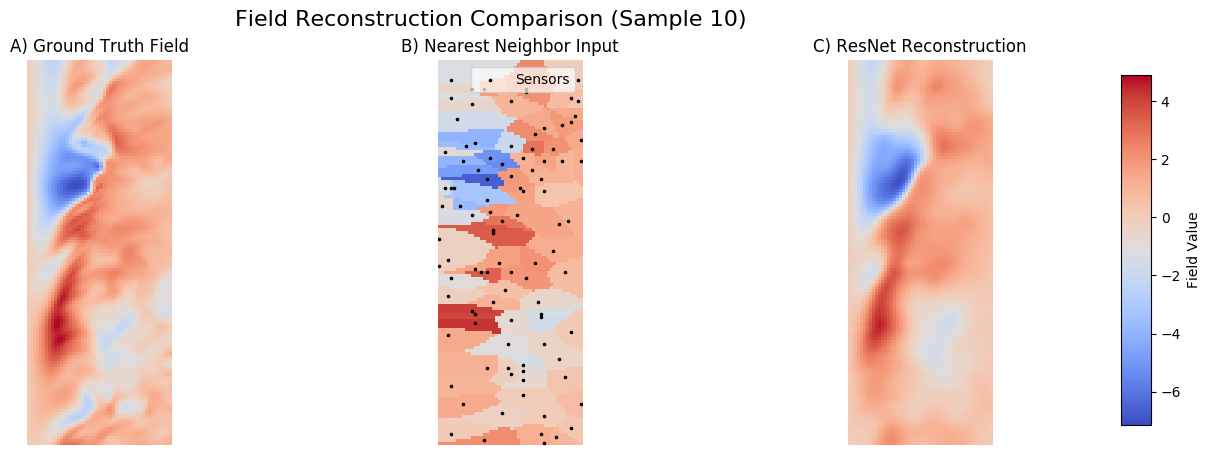


Prediction MSE (on this sample): 0.446628


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
import matplotlib.pyplot as plt


device = 'cuda' 
if not torch.cuda.is_available():
    device = 'cpu'
    print("⚠️ CUDA not available. Running on CPU.")


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += shortcut
        out = F.relu(out)
        return out

class ResNetReconstructor(nn.Module):
    def __init__(self, dim_1, dim_2):
        super(ResNetReconstructor, self).__init__()
        
        self.initial_conv = nn.Conv2d(2, 64, kernel_size=5, padding='same')
        self.initial_bn = nn.BatchNorm2d(64)
        
        self.res1 = ResidualBlock(64, 64, dropout_rate=0.1)
        self.res2 = ResidualBlock(64, 64, dropout_rate=0.1)
        
        self.res3 = ResidualBlock(64, 128, dropout_rate=0.2)
        self.res4 = ResidualBlock(128, 128, dropout_rate=0.2)
        
        self.res_added_1 = ResidualBlock(128, 128, dropout_rate=0.2) 
        self.res_added_2 = ResidualBlock(128, 128, dropout_rate=0.2) 
        
        self.res5 = ResidualBlock(128, 64, dropout_rate=0.1) 
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding='same')

    def forward(self, x):
        x = F.relu(self.initial_bn(self.initial_conv(x)))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        
        x = self.res_added_1(x) 
        x = self.res_added_2(x) 
        
        x = self.res5(x)
        
        x = self.final_conv(x)
        return x


dim_1 = 128
dim_2 = 48
num_snapshots = 5000
sen_num_kind = 1
sen_num_var = 1
sen_num_kind_list = [100]
sen_num_var_list = [300]

try:
    xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
    ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
    xc = xcor[0:dim_1, 0]
    yc = ycor[0:dim_2, 0]
    with open("./ch_2Dxysec.pickle", 'rb') as f:
        omg_flc_all = pickle.load(f)
except FileNotFoundError as e:
    print(f"ERROR: Data file not found for loading: {e.filename}. Cannot proceed.")
    exit()

x_ref, y_ref = np.meshgrid(yc, xc)
total_samples = num_snapshots * sen_num_kind * sen_num_var
X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
y_ki = np.zeros((total_samples, dim_1, dim_2, 1))
sample_index = 0
sen_num = sen_num_kind_list[0]
va = sen_num_var_list[0]

for t in range(num_snapshots):
    y_ki[sample_index, :, :, 0] = omg_flc_all[t, :, :, 0]
    
    np.random.seed(va)
    sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
    sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

    sparse_data = np.zeros(sen_num)
    for s in range(sen_num):
        sparse_data[s] = omg_flc_all[t, :, :, 0][
            int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
        ]

    sparse_locations_ex = np.zeros((sen_num, 2))
    for i in range(sen_num):
        sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
        sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

    grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
    X_ki[sample_index, :, :, 0] = grid_z0

    mask_img = np.zeros(grid_z0.shape)
    for i in range(sen_num):
        mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
    X_ki[sample_index, :, :, 1] = mask_img
    
    sample_index += 1

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_ki, y_ki, test_size=0.3, random_state=42
)

# Convert to Tensors and permute for PyTorch (N, H, W, C) -> (N, C, H, W)
X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)


model = ResNetReconstructor(dim_1, dim_2).to(device)
model_save_path = './Model_ResNet_2Dxysec_weights.pth'

try:

    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval() # Set model to evaluation mode
    print(f"Successfully loaded enhanced weights from {model_save_path}")
except FileNotFoundError:
    print(f"ERROR: Model weights file not found at {model_save_path}. Please ensure you ran the training script with the enhanced model first.")
    exit()

sample_idx = 10 
print(f"Generating prediction for sample index {sample_idx} from the test set...")

x_sample = X_test_tensor[sample_idx:sample_idx+1]
y_true = y_test_tensor[sample_idx]

with torch.no_grad():
    y_pred_tensor = model(x_sample)


x_input_np = x_sample.cpu().numpy()[0, 0, :, :] 
x_mask_np = x_sample.cpu().numpy()[0, 1, :, :] 
y_true_np = y_true.cpu().numpy()[0, :, :]      
y_pred_np = y_pred_tensor.cpu().numpy()[0, 0, :, :] 

def plot_field(data, title, ax):
    """Utility function to plot a 2D field with consistent settings."""
    v_min = y_true_np.min()
    v_max = y_true_np.max()
    
    im = ax.imshow(data, cmap='coolwarm', origin='lower', vmin=v_min, vmax=v_max)
    ax.set_title(title)
    ax.axis('off')
    return im

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = plot_field(y_true_np, "A) Ground Truth Field", axes[0])

im2 = plot_field(x_input_np, "B) Nearest Neighbor Input", axes[1])
sensor_locs = np.argwhere(x_mask_np == 1)
if sensor_locs.size > 0:
    axes[1].scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='k', marker='.', s=10, label='Sensors')
    axes[1].legend(loc='upper right', framealpha=0.7)

im3 = plot_field(y_pred_np, "C) ResNet Reconstruction", axes[2])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Field Value')

plt.suptitle(f"Field Reconstruction Comparison (Sample {sample_idx})", fontsize=16)
plt.show()

error = np.mean((y_true_np - y_pred_np)**2)
print(f"\nPrediction MSE (on this sample): {error:.6f}")

In [ ]:
print("\nCalculating Final Mean Test MSE and RMSE using best weights...")

model.eval()
total_test_mse = 0.0
final_criterion = nn.MSELoss() 

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        outputs = model(inputs)
        batch_mse = final_criterion(outputs, targets)
        total_test_mse += batch_mse.item()

mean_test_mse = total_test_mse / len(test_loader)
mean_test_rmse = np.sqrt(mean_test_mse) 

print(f"\nFinal Test Set Results:")
print(f"  Total Test Samples: {len(X_test_tensor)}")
print(f"  Mean Test MSE: {mean_test_mse:.8f}")




Calculating Final Mean Test MSE and RMSE using best weights...


Testing: 100%|██████████| 47/47 [00:01<00:00, 31.57it/s]


Final Test Set Results:
  Total Test Samples: 1500
  Mean Test MSE: 0.46103845
